In [20]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

In [21]:
df_train = pd.read_csv('./Housing Dreams/house_train_raw.csv')
df_test = pd.read_csv('./Housing Dreams/houses_test_raw.csv')

# EDA

In [22]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Procedo a estudiar los NAN y duplicados en el dataset.

In [23]:
#Borro la columna ID, que no contiene información relevante
df_train.drop(['Id'], axis=1, inplace=True)
df_test.drop(['Id'], axis=1, inplace=True)

In [24]:
# Busco las columnas que contienen valores nulos
missing = df_train.isnull().sum()
missing = missing[missing.values>0]
print(f'Hay {len(missing)} columnas con datos faltantes:')
print(missing.sort_values(ascending=False))

Hay 19 columnas con datos faltantes:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


Veo que el dataset contiene 19 columnas con datos faltantes. Pero de esos 19, 16 contienen valores faltantes como categoría. O sea, contienen valores nulos porque es la descripción de ausencia de la característica y no por error. Por lo tanto, procedo a incluirla como característica en estas 16 columnas.

In [25]:
# Columnas que contienen NaN como categoría propia
NA_category = ['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [26]:
df_train[NA_category] = df_train[NA_category].fillna('Not Applicable')
df_test[NA_category] = df_test[NA_category].fillna('Not Applicable')

In [27]:
# La columna 'MasVnrArea' contiene valores nulos, pero es numérica, por lo que reemplazo esos valores por 0.
df_train['MasVnrArea'] = df_train['MasVnrArea'].apply(lambda x: 0 if isinstance(x, str) else x)
df_test['MasVnrArea'] = df_test['MasVnrArea'].apply(lambda x: 0 if isinstance(x, str) else x)

Ahora sí busco las columnas que contienen datos faltantes de verdad.

In [28]:
#Busco las columnas que tienen valores faltantes
new_miss = missing.reset_index().rename(columns={0:'missing'})
new_miss = new_miss[~new_miss['index'].isin(NA_category)]
new_miss['Percentage'] = new_miss['missing'].apply(lambda x: round(x/df_train.shape[0]*100,2))
new_miss

,index,missing,Percentage
0,LotFrontage,259,17.74
9,Electrical,1,0.07
12,GarageYrBlt,81,5.55


In [29]:
df_train[['LotFrontage', 'Electrical', 'GarageYrBlt']].describe(include='all')

,LotFrontage,Electrical,GarageYrBlt
count,1201.000000,1459,1379.000000
unique,NaN,5,NaN
top,NaN,SBrkr,NaN
freq,NaN,1334,NaN
mean,70.049958,NaN,1978.506164
std,24.284752,NaN,24.689725
min,21.000000,NaN,1900.000000
25%,59.000000,NaN,1961.000000
50%,69.000000,NaN,1980.000000
75%,80.000000,NaN,2002.000000


Como veo en los cuadros de arriba, los valores faltantes de estas 3 columnas no son tan considerables en cantidad. Hay 2 columnas que contienen datos numéricos y otra que contiene datos en texto.<br>
De estas dos columnas con datos numéricos, una corresponde a años, que es mejor tratarla como categórico, por lo que incluiré la moda en los valores faltantes (ya que años en decimales no tiene mucho sentido).<br>
Para la columna 'LotFrontage' incluiré la mediana de los valores de la columna, ya que no dista casi nada con el valor de la media, y va mejor con el formato sin decimales del resto de valores.<br>
Al único valor faltante de la columna 'Electrical' lo reemplazaré por su moda.

In [30]:
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(df_train['LotFrontage'].mean())
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(0)
df_test['LotFrontage'] = df_test['LotFrontage'].fillna(df_train['LotFrontage'].mean())
df_test['Electrical'] = df_test['Electrical'].fillna(df_train['Electrical'].mode()[0])
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(0)

Transformo los años a texto para tratarlas como categóricas. También la columna 'MSSubClass' contiene valores numéricos que representan clases, por lo tanto, transformo los valores a texto.

In [31]:
numeric_categoric = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

for column in numeric_categoric:
    df_train[column] = df_train[column].astype(str)
    df_test[column] = df_test[column].astype(str)

In [32]:
df_train.iloc[:,:50].describe()

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,6.099315,5.575342,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877
std,22.024023,9981.264932,1.382997,1.112799,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885
min,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000
50%,70.049958,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000
75%,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000
max,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000


In [33]:
df_train.iloc[:,50:].describe()

,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890
std,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883
min,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000
25%,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000
50%,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000
75%,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000
max,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000


In [34]:
corr_sales = df_train.corr().sort_values(by='SalePrice', ascending=False)[['SalePrice']]
corr_sales

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
MasVnrArea,0.472614


In [35]:
# Busco los valores de correlación más bajos con la columna SalePrice
corr_sales[(corr_sales['SalePrice'] < 0.1) & (corr_sales['SalePrice'] > -0.1)].reset_index()

,index,SalePrice
0,PoolArea,0.092404
1,MoSold,0.046432
2,3SsnPorch,0.044584
3,BsmtFinSF2,-0.011378
4,BsmtHalfBath,-0.016844
5,MiscVal,-0.021190
6,LowQualFinSF,-0.025606
7,OverallCond,-0.077856


Tengo 8 valores con una correlación muy baja con el precio.

<AxesSubplot:>

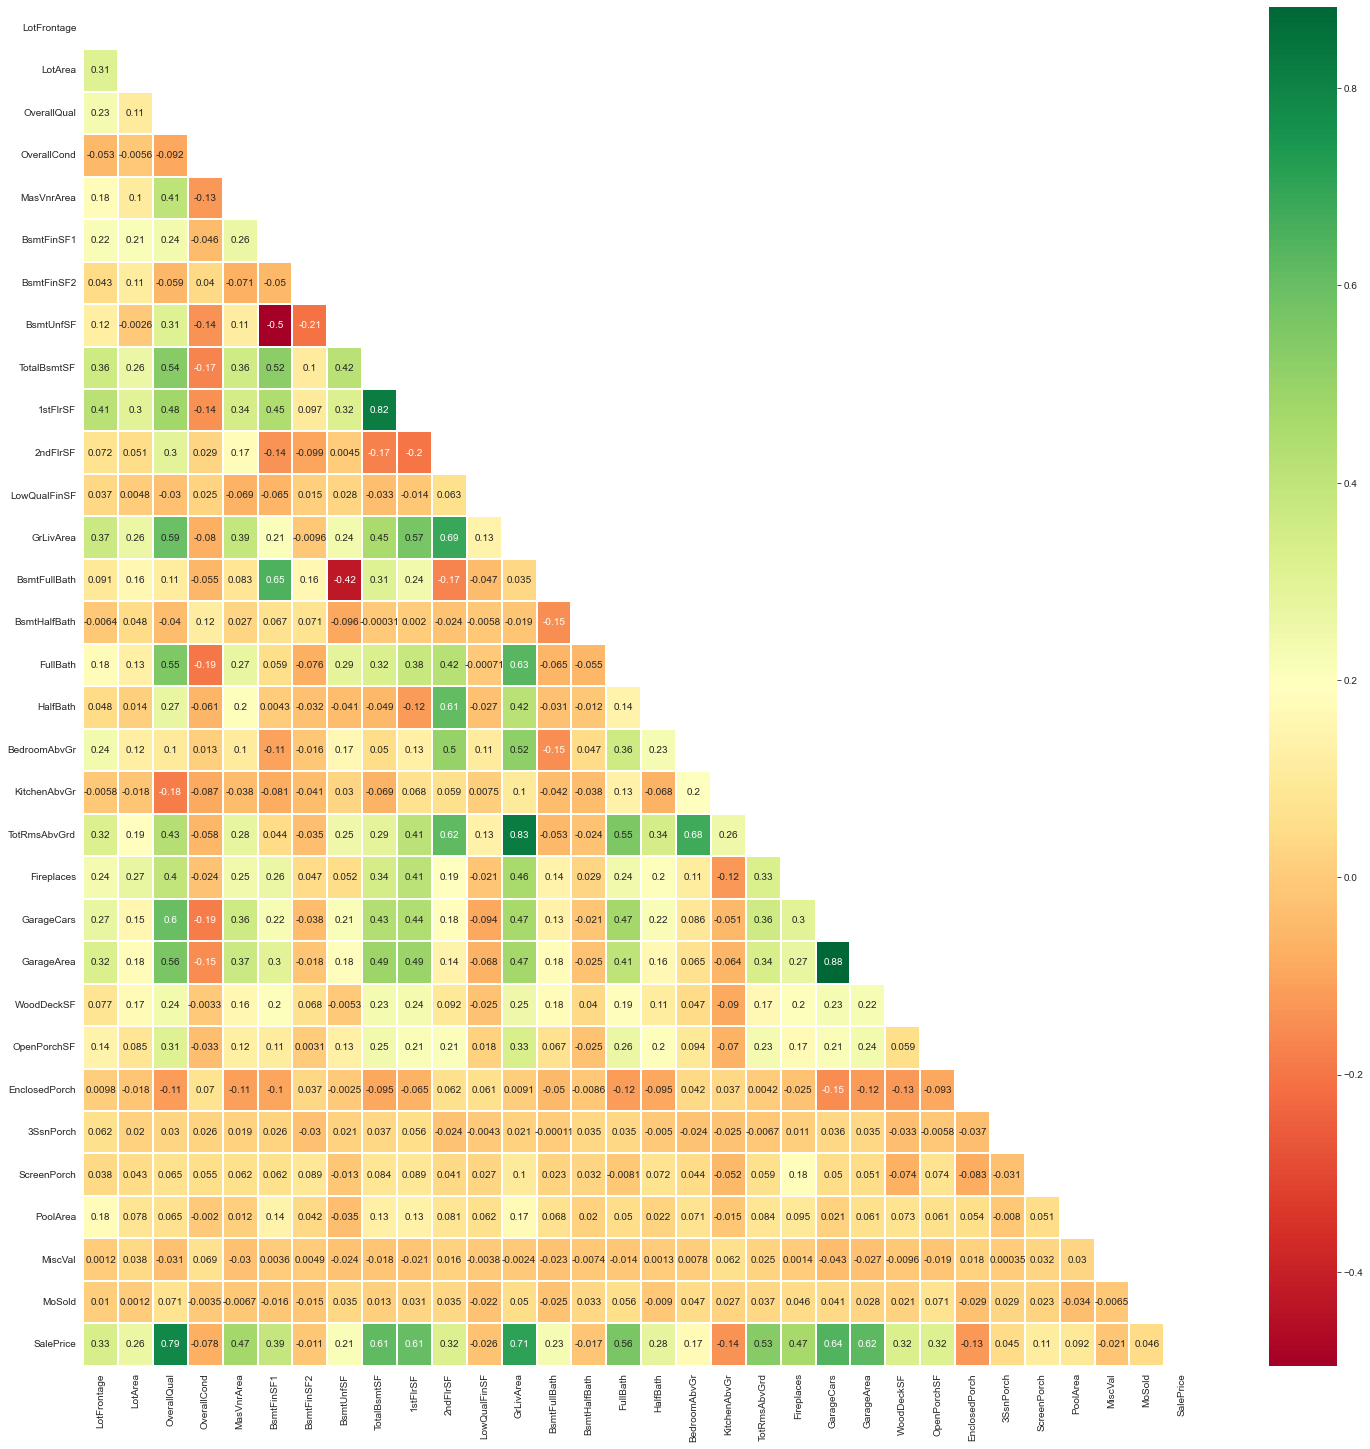

In [36]:
#heatmap
corr = df_train.corr()
sns.set_style("whitegrid")
plt.figure(figsize=(25,25))
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap='RdYlGn', linewidths=0.2, mask=mask)

Hay muchas columnas con correlaciones altas entre si, por lo que utilizasr modelos lineales no termina siendo recomendable, ya que estos son susceptibles a combinaciones lineales entre los features.

In [37]:
categorics = []
for i in df_train.columns:
    if df_train[i].dtype == object:
        categorics.append(i)
df_train[categorics].transpose()

,0,1,2,3,4,5,6,7,8,9,...,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
MSSubClass,60,20,60,70,60,50,20,60,50,190,...,90,20,180,20,20,60,20,70,20,20
MSZoning,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL,...,RL,RL,RM,RL,FV,RL,RL,RL,RL,RL
Street,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,...,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave
Alley,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,...,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Pave,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable
LotShape,Reg,Reg,IR1,IR1,IR1,IR1,Reg,IR1,Reg,Reg,...,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,...,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,...,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub
LotConfig,Inside,FR2,Inside,Corner,FR2,Inside,Inside,Corner,Inside,Corner,...,FR2,Inside,Inside,Inside,Inside,Inside,Inside,Inside,Inside,Inside
LandSlope,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,...,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl,Gtl
Neighborhood,CollgCr,Veenker,CollgCr,Crawfor,NoRidge,Mitchel,Somerst,NWAmes,OldTown,BrkSide,...,NAmes,Somerst,Edwards,Mitchel,Somerst,Gilbert,NWAmes,Crawfor,NAmes,Edwards


In [39]:
# Creo los encodings de las variables categóricas
enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
transformed = enc.fit_transform(df_train[categorics])
transformed_test = enc.transform(df_test[categorics])
temp = pd.DataFrame(data=transformed, columns=enc.get_feature_names(categorics))
temp_test = pd.DataFrame(data=transformed_test, columns=enc.get_feature_names(categorics))
df_train.drop(columns=categorics, inplace=True)
df_test.drop(columns=categorics, inplace=True)
df_train = pd.concat([df_train, temp], axis=1)
df_test = pd.concat([df_test, temp_test], axis=1)

c:\Users\carma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\carma\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Entrenamiento y selección de modelo

In [40]:
#Separo los datos en train y test
x = df_train.drop(columns=['SalePrice'])
y = df_train['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [41]:
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

La idea es probar con varios modelos y ver cuáles me dan mejores resultados de manera pura y rápida, para posteriormente retocar aquel que mejor se ajuste a los datos.

In [42]:
lasso = LassoCV()
svr = SVR()
rf = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()

In [43]:
models = [lasso.fit(x_train, y_train), svr.fit(x_train, y_train), rf.fit(x_train, y_train), gbr.fit(x_train, y_train), xgb.fit(x_train, y_train)]
rmsle = [mean_squared_log_error(y_test, model.predict(x_test), squared=False) for model in models]
r2 = [r2_score(y_test, model.predict(x_test)) for model in models]
ev = pd.DataFrame({'Model': ['lasso', 'svr', 'rf', 'gbr', 'xgb'], 'rmsle': rmsle, 'r2': r2})
ev

c:\Users\carma\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model,rmsle,r2
0,lasso,0.212862,0.731579
1,svr,0.412760,-0.033161
2,rf,0.148489,0.865400
3,gbr,0.138239,0.859241
4,xgb,0.144410,0.873076


Como puedo observar en la tabla anterior, los 3 mejores modelos que se ajustan al resultado (R2) y que menor error generan (rmsle) son los modelos Random Forest, Gradient Boosting Regressor y XGBoost con resultados muy similares.

# Más feature engineering

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

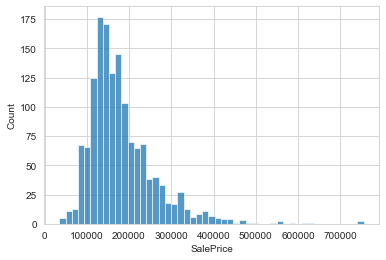

In [44]:
sns.histplot(df_train['SalePrice'])

Acá puedo observar que el precio no sigue una distribución normal, condición importante para muchos modelos.<br>
Si realizo una pequeña transformación a la columna SalePrice, en este caso, logarítmica, podría obtener una mejor aproximación de la distribución.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

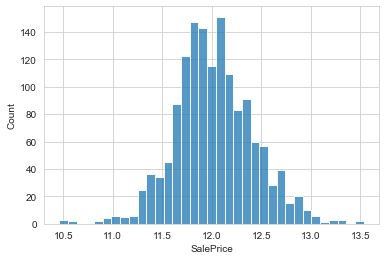

In [45]:
sns.histplot(df_train['SalePrice'].apply(np.log))

Justo como esperado, la distribución se parece un poco más a la normal.<br>
Ahora vuelvo a entrenar los modelos para ver en qué tanto afectó la transformación.

In [46]:
x = df_train.drop(columns=['SalePrice'])
y_log = df_train['SalePrice'].apply(np.log)
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(x, y_log, test_size=0.33, random_state=42)

In [47]:
models = [lasso.fit(x_train_log, y_train_log), svr.fit(x_train_log, y_train_log), rf.fit(x_train_log, y_train_log), gbr.fit(x_train_log, y_train_log), xgb.fit(x_train_log, y_train_log)]
rmsle = [mean_squared_log_error(y_test_log, model.predict(x_test_log), squared=False) for model in models]
r2 = [r2_score(y_test_log, model.predict(x_test_log)) for model in models]
ev2 = pd.DataFrame({'Model': ['lasso', 'svr', 'rf', 'gbr', 'xgb'], 'rmsle': rmsle, 'r2': r2})
ev2

c:\Users\carma\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model,rmsle,r2
0,lasso,0.016444,0.737999
1,svr,0.016153,0.747915
2,rf,0.011327,0.876727
3,gbr,0.010984,0.881257
4,xgb,0.012282,0.850719


Obtuvimos errores con un orden de magnitud de diferencia. Los ajustes no son tan diferentes antes o después de la transformación, pero los errores sí variaron bastante. De todos modos, los 3 modelos que mejor funcionan siguen siendo los mismos.

Gradient Boosting Regressor es el mejor modelo con los datos obtenidos hasta ahora. Se podría mejorar más trabajando aún más sobre los features e hiperparámetros.

Ahora procedo a trabajar sobre el dataset de Test.

In [54]:
missing_test = df_test.isnull().sum()
missing_test = missing_test[missing_test.values>0]
print(f'Hay {len(missing_test)} columnas con datos faltantes:')
print(missing_test.sort_values(ascending=False))

Hay 8 columnas con datos faltantes:
BsmtFullBath    2
BsmtHalfBath    2
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
GarageCars      1
GarageArea      1
dtype: int64


In [60]:
null_columns_test = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
for column in null_columns_test:
    df_test[column] = df_test[column].fillna(df_test[column].mean())

In [61]:
predictions = gbr.predict(df_test)
predictions = np.exp(predictions)

In [63]:
predictions = pd.DataFrame({'SalePrice': predictions})
predictions.to_csv('predictions.csv', index=False)